In [1]:
import pandas as pd
pd.set_option('future.no_silent_downcasting', True)

import matplotlib.pyplot as plt
import numpy as np
import scienceplots
import os

os.environ["PATH"] += os.pathsep + '/Library/TeX/texbin'
plt.style.use(['science',"ieee"])

In [30]:
def generate_projection_plots(country, gr=0.04,gr_type='average',num_periods=15, save_fig=True):
    df = pd.read_excel('~/Desktop/MKTP_GDP.xls')
    names = df["Data Source"]

    try:
        country_index = names[names == country.title()].index[0]
    except IndexError:
        print(f"Country {country} not found")
        return
    ground_data = df.iloc[country_index, 4:]
    xs = [x + 1960 for x in range(len(ground_data))]
    cols = [str(x) for x in xs]

    # Assign the new index to the series
    ground_data.index = cols
    series = ground_data["1960":"2007"]

    mean = series.pct_change().dropna().mean()
    gdp_85_07 = ground_data["1985":"2007"]
    gdp_90_07 = ground_data["1990":"2007"]
    growth_rates_85_07 = gdp_85_07.pct_change().dropna().mean()
    growth_rates_90_07 = gdp_90_07.pct_change().dropna().mean()
    growth_rate = gdp_90_07.pct_change().dropna().mean()

    gdp_post07 = ground_data["2008":]
    growth_rate_post07 = gdp_post07.pct_change().dropna().mean()

    if gr_type == 'average':
        growth_rate = series.pct_change().dropna().mean()
    elif gr_type == 'median':
        growth_rate = series.pct_change().dropna().median()
    elif gr_type == '85s':
        growth_rate = gdp_85_07.pct_change().dropna().mean()
    elif gr_type == '90s':
        growth_rate = gdp_90_07.pct_change().dropna().mean()
    elif gr_type == 'post07':
        growth_rate = gdp_post07.pct_change().dropna().mean()
    elif gr_type == 'set':
        while True:
            try:
                lb, up = input("Enter the Start and end year for growth calculation (space separated): ").split()
                break  # If input is correct, exit the loop
            except ValueError:
                print("Invalid input. Please enter the Start and end year correctly, separated by a space.")

        gdp_range = ground_data[lb:up]
        growth_rate = gdp_range.pct_change().dropna().mean()
    elif gr_type == 'custom':
        growth_rate = gr

    # Calculate Projection
    # Last value in the series
    last_value = series.iloc[-1]

    # Generate projections
    projections = [last_value * (1 + growth_rate) ** i for i in range(1, num_periods + 1)]

    # Create a new series from the projections
    projection_series = pd.Series(projections, index=[f"{i}" for i in range(2007 + 1, 2007 + num_periods + 1)])

    # Extend the original series with the projections
    extended_series = pd.concat([series, projection_series], ignore_index=False)

    # Ensure both series are numeric
    extended_series = pd.to_numeric(extended_series, errors='coerce')
    gdp = pd.to_numeric(ground_data, errors='coerce')

    # Drop any NaN values that might have been introduced by coercion
    extended_series.dropna(inplace=True)
    gdp.dropna(inplace=True)

    # Calculate the difference for values in the extended series and the GDP after 2007
    gdp_post07_difference = extended_series["2008":] - gdp["2008":]
    print(np.sum(gdp_post07_difference * 1e+6))

    # Reset indices or use a numeric range for x-axis
    years = [f"{x[2:]}" for x in extended_series.index]
    years = list(extended_series.index)
    years_numeric = range(len(years))
    plt.figure(figsize=(10, 6))
    plt.title(f'GDP Growth Projection for {country.title()}')  # Added title for the plot
    plt.plot(
        years_numeric,
        extended_series,
        label=f'Projected GDP Growth with {growth_rate * 100:.2f}\% \
            Ref: 1960-2007 = {mean * 100:.2f}\% \
                 1985-2007 = {growth_rates_85_07 * 100:.2f}\% \
                 1990-2007 = {growth_rates_90_07 * 100:.2f}\%')

    plt.plot(years_numeric[:len(gdp)], gdp, label=f'Real GDP / Post-GFC Growth Rate: {growth_rate_post07 * 100:.2f}\%')  # Adjust the range if necessary
    plt.fill_between(years_numeric, extended_series, gdp[:len(extended_series)],
                     where=np.logical_or(extended_series > gdp[:len(extended_series)], extended_series.index == '2007'),
                     color='red', alpha=0.3, label=f'Lost GDP')

    if country:
        # Add gray shaded areas for NBER declared recessions since 1980
        recessions = {
            '1980-1982': ('1980', '1982'),
            '1990-1991': ('1990', '1991'),
            '2001': ('2001', '2001'),
            '2007-2009': ('2007', '2009'),
            '2020': ('2020', '2020'),
        }

        recession_label = ['1980s Recession', '1990s Recession', 'Dot Com Recession', 'GFC', 'Covid-19']
        shades_of_Gray = ['gray', 'gainsboro', 'lightgray', 'dimgray', 'darkgray']

        for _, (start, end) in recessions.items():
            start_index = years_numeric[years.index(start)]
            end_index = years_numeric[years.index(end)] + 1  # +1 to include the end year in the shading
            plt.fill_betweenx([min(min(extended_series), min(gdp)), max(max(extended_series), max(gdp))], start_index, end_index, color=shades_of_Gray.pop(0), alpha=0.3, label=recession_label.pop(0))

    # Set x-ticks to display only every 5th year
    every_fifth_year = range(0, len(years), 5)
    plt.xticks(every_fifth_year, [years[i] for i in every_fifth_year])
    plt.legend()

    if save_fig:
        plt.savefig(f"{country}_projection.png")
    plt.show()


1.8372679916558174e+19


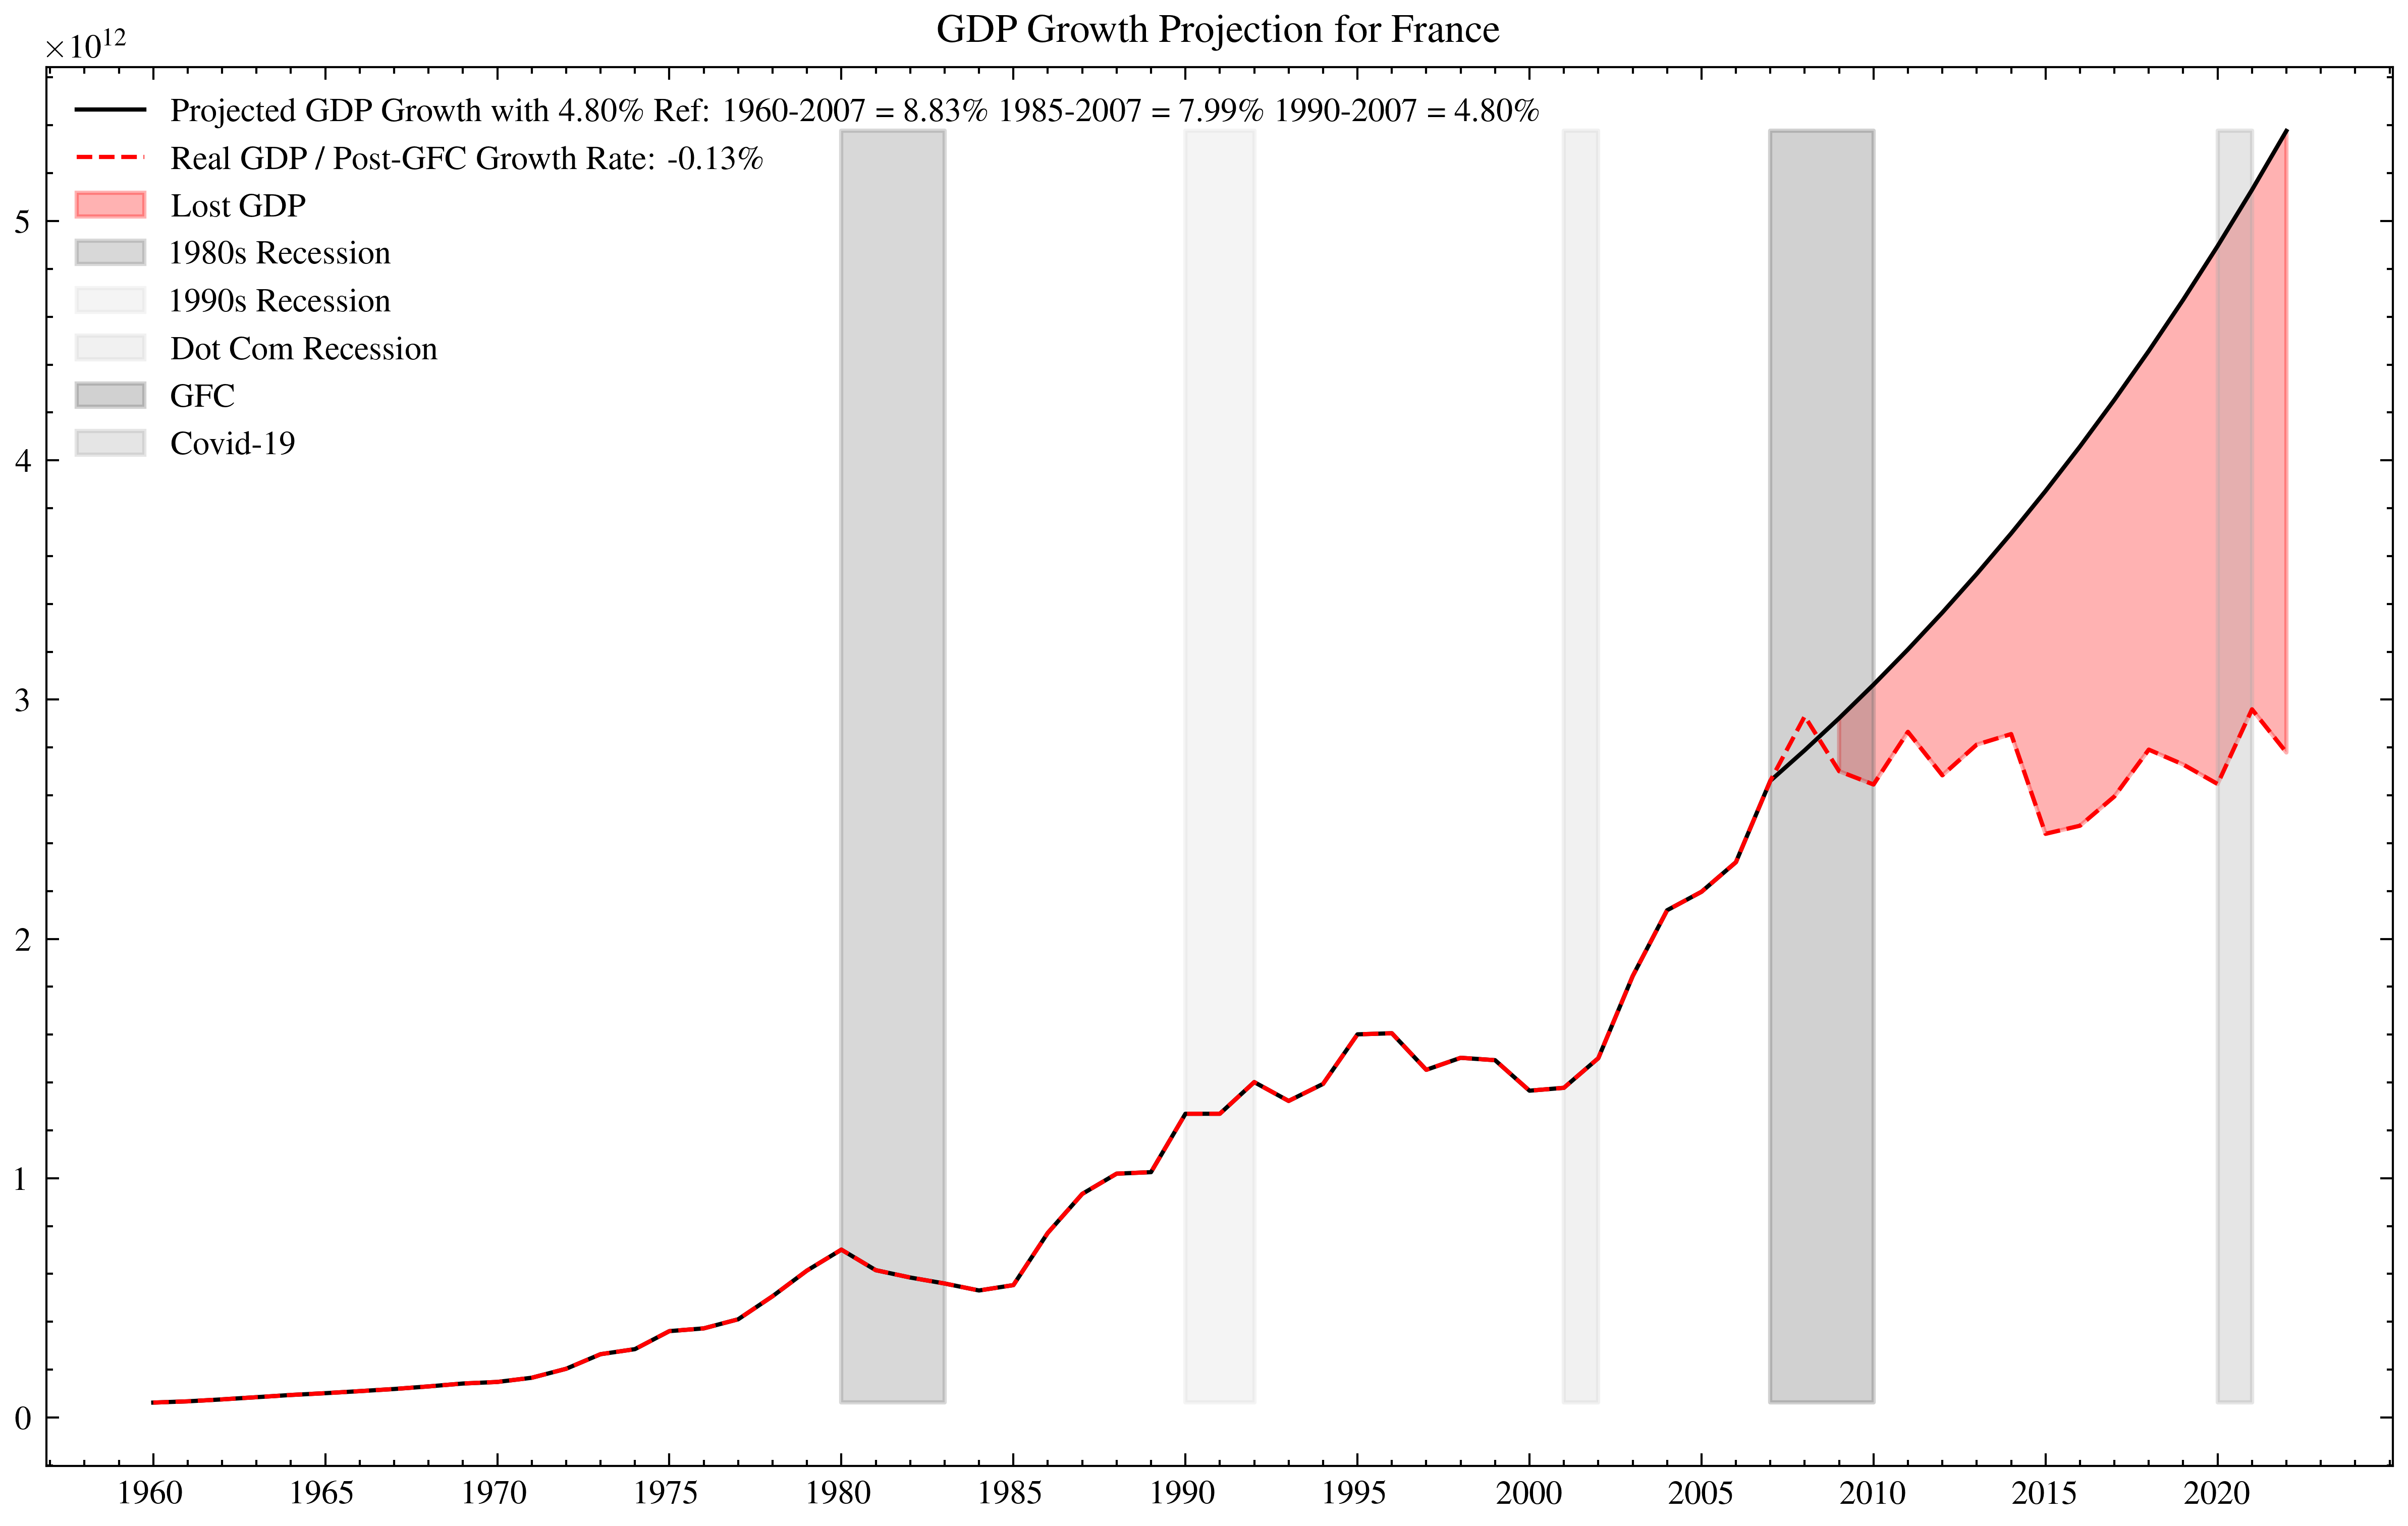

In [35]:

generate_projection_plots("France", gr=0.04, gr_type='90s', num_periods=15, save_fig=True)
